### Exercise 1.1: A baseline MLP

#### Imports and Dataset

In [91]:
import numpy as np
import torch
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from dataclasses import dataclass
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models.resnet import BasicBlock
from tqdm import tqdm
import os

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### MLP e Configuration

In [17]:
@dataclass
class Config:
    batch_size: int = 128
    learning_rate: float = 1e-3
    epochs: int = 10
    hidden_layer_sizes: list = None
    log_dir: str = "runs/mnist_mlp_experiment"
    device: torch.device = device
    input_size: int = 28*28
    num_classes: int = 10
    activation_class: type = nn.ReLU   
    name: str = None                   

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, num_classes, activation_class=nn.ReLU):
        super().__init__()
        layers = [nn.Flatten()]

        for hidden_layer_size in hidden_layer_sizes:
            layers.append(nn.Linear(input_size, hidden_layer_size))
            layers.append(activation_class())
            input_size = hidden_layer_size

        layers.append(nn.Linear(input_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#### Training utilities

In [19]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch=None):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}" if epoch is not None else "Train", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=running_loss/total_samples, acc=running_corrects/total_samples)

    average_loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    return average_loss, accuracy


def evaluate(model, dataloader, criterion, device, split_name="Test"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(dataloader, desc=split_name, leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

            loop.set_postfix(loss=running_loss/total_samples, acc=running_corrects/total_samples)

    average_loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    return average_loss, accuracy


def assign_name(config):
    config.name = f"MLP_{'-'.join(map(str, config.hidden_layer_sizes))}"
    return config


In [20]:
def run_experiments(configs):
    results = []

    for config in configs:
        config = assign_name(config)
        print(f"\nRunning experiment: {config.name}")

        train_loader = torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True)
        test_loader  = torch.utils.data.DataLoader(ds_test, batch_size=config.batch_size, shuffle=False)

        model = MLP(input_size=config.input_size,
                    hidden_layer_sizes=config.hidden_layer_sizes,
                    num_classes=config.num_classes,
                    activation_class=config.activation_class).to(config.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        writer = SummaryWriter(log_dir=f"{config.log_dir}/{config.name}")

        best_test_acc = 0.0
        best_epoch = 0

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device, epoch)
            test_loss, test_acc = evaluate(model, test_loader, criterion, config.device, split_name="Test")

            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("Accuracy/test", test_acc, epoch)

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch = epoch + 1  

        writer.close()

        print(f"Model {config.name} | Best Test Acc: {best_test_acc:.4f} reached at epoch {best_epoch}")

        results.append({
            "model": config.name,
            "best_test_acc": best_test_acc,
            "best_epoch": best_epoch
        })

    df = pd.DataFrame(results)
    print("\nSummary of best test accuracies per model")
    print(df)
    return df

In [21]:
configs = [
    Config(hidden_layer_sizes=[16,16], epochs=11),
    Config(hidden_layer_sizes=[64,32,16], epochs=11),
    Config(hidden_layer_sizes=[256,128], epochs=11),
]

summary_df = run_experiments(configs)


Running experiment: MLP_16-16


Model MLP_16-16 | Best Test Acc: 0.9541 reached at epoch 11

Running experiment: MLP_64-32-16


Model MLP_64-32-16 | Best Test Acc: 0.9712 reached at epoch 11

Running experiment: MLP_256-128


Model MLP_256-128 | Best Test Acc: 0.9816 reached at epoch 10

Summary of best test accuracies per model
          model  best_test_acc  best_epoch
0     MLP_16-16         0.9541          11
1  MLP_64-32-16         0.9712          11
2   MLP_256-128         0.9816          10


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [29]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, hidden_size, num_layers=2, activation_class=nn.ReLU):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_class())
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)   

    
class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_blocks, num_layers_per_block=2, num_classes=10, activation_class=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_layer = nn.Linear(input_size, hidden_size)

        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualMLPBlock(hidden_size, num_layers_per_block, activation_class))
        self.blocks = nn.Sequential(*blocks)

        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.input_layer(x)   
        x = self.blocks(x)
        return self.output_layer(x)

#### Expand Config and run_experiments to include the ResidualMLP

In [37]:
@dataclass
class Config:
    batch_size: int = 128
    learning_rate: float = 0.0001
    epochs: int = 10
    log_dir: str = "runs/mnist_mlp_residual_experiment"
    device: torch.device = device
    input_size: int = 28*28
    num_classes: int = 10
    activation_class: type = nn.ReLU
    name: str = None

    # previous MLP 
    hidden_layer_sizes: list = None 

    # for ResidualMLP
    hidden_size: int = None
    num_blocks: int = None
    num_layers_per_block: int = 1
    
def assign_name(config, model_type="MLP"):
    if model_type == "MLP":
        depth = len(config.hidden_layer_sizes)
        first_size = config.hidden_layer_sizes[0] if depth > 0 else "None"
        config.name = f"MLP_{first_size}x{depth}"  # e.g., MLP_16x16
    elif model_type == "ResidualMLP":
        config.name = f"ResMLP_hidden{config.hidden_size}_blocks{config.num_blocks}_layersPerBlock{config.num_layers_per_block}"
    return config

def run_experiments(configs, model_class=MLP, model_type="MLP"):
    results = []

    for config in configs:
        config = assign_name(config, model_type=model_type)
        print(f"\nRunning experiment: {config.name}")

        train_loader = torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True)
        test_loader  = torch.utils.data.DataLoader(ds_test, batch_size=config.batch_size, shuffle=False)

        if model_type == "MLP":
            model = model_class(
                input_size=config.input_size,
                hidden_layer_sizes=config.hidden_layer_sizes,
                num_classes=config.num_classes,
                activation_class=config.activation_class
            ).to(config.device)
        elif model_type == "ResidualMLP":
            model = model_class(
                input_size=config.input_size,
                hidden_size=config.hidden_size,
                num_blocks=config.num_blocks,
                num_layers_per_block=config.num_layers_per_block,
                num_classes=config.num_classes,
                activation_class=config.activation_class
            ).to(config.device)
        else:
            raise ValueError(f"Unknown model_type: {model_type}")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        writer = SummaryWriter(log_dir=f"{config.log_dir}/{config.name}")

        best_test_acc = 0.0
        best_epoch = 0

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device, epoch)
            test_loss, test_acc = evaluate(model, test_loader, criterion, config.device, split_name="Test")

            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("Accuracy/test", test_acc, epoch)

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch = epoch + 1  

        writer.close()

        print(f"Model {config.name} | Best Test Acc: {best_test_acc:.4f} reached at epoch {best_epoch}")

        results.append({
            "model": config.name,
            "best_test_acc": best_test_acc,
            "best_epoch": best_epoch
        })

    df = pd.DataFrame(results)
    print("\nSummary of best test accuracies per model")
    print(df)
    return df


In [38]:
configs_mlp = [
    Config(hidden_layer_sizes=[16]*2, epochs=21),
    Config(hidden_layer_sizes=[16]*8, epochs=21),
    Config(hidden_layer_sizes=[16]*32, epochs=21),
    Config(hidden_layer_sizes=[16]*64, epochs=21),
]

configs_residual = [
    Config(hidden_size=16, num_blocks=2, num_layers_per_block=1, epochs=21),
    Config(hidden_size=16, num_blocks=8, num_layers_per_block=1, epochs=21),
    Config(hidden_size=16, num_blocks=32, num_layers_per_block=1, epochs=21),
    Config(hidden_size=16, num_blocks=64, num_layers_per_block=1, epochs=21),
]

In [39]:
summary_mlp = run_experiments(configs_mlp, model_class=MLP, model_type="MLP")
summary_residual = run_experiments(configs_residual, model_class=ResidualMLP, model_type="ResidualMLP")


Running experiment: MLP_16x2


Model MLP_16x2 | Best Test Acc: 0.9316 reached at epoch 21

Running experiment: MLP_16x8


Model MLP_16x8 | Best Test Acc: 0.8767 reached at epoch 21

Running experiment: MLP_16x32


Model MLP_16x32 | Best Test Acc: 0.1135 reached at epoch 3

Running experiment: MLP_16x64


Model MLP_16x64 | Best Test Acc: 0.1135 reached at epoch 2

Summary of best test accuracies per model
       model  best_test_acc  best_epoch
0   MLP_16x2         0.9316          21
1   MLP_16x8         0.8767          21
2  MLP_16x32         0.1135           3
3  MLP_16x64         0.1135           2

Running experiment: ResMLP_hidden16_blocks2_layersPerBlock1


Model ResMLP_hidden16_blocks2_layersPerBlock1 | Best Test Acc: 0.9400 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks8_layersPerBlock1


Model ResMLP_hidden16_blocks8_layersPerBlock1 | Best Test Acc: 0.9527 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks32_layersPerBlock1


Model ResMLP_hidden16_blocks32_layersPerBlock1 | Best Test Acc: 0.9462 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks64_layersPerBlock1


Model ResMLP_hidden16_blocks64_layersPerBlock1 | Best Test Acc: 0.3560 reached at epoch 21

Summary of best test accuracies per model
                                      model  best_test_acc  best_epoch
0   ResMLP_hidden16_blocks2_layersPerBlock1         0.9400          21
1   ResMLP_hidden16_blocks8_layersPerBlock1         0.9527          21
2  ResMLP_hidden16_blocks32_layersPerBlock1         0.9462          21
3  ResMLP_hidden16_blocks64_layersPerBlock1         0.3560          21


#### Check sensitivity to changes in the n of layer inside the residual blocks

In [43]:
configs_residual = [
    Config(hidden_size=16, num_blocks=1, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
    Config(hidden_size=16, num_blocks=4, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
    Config(hidden_size=16, num_blocks=16, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
    Config(hidden_size=16, num_blocks=32, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
]
summary_residual = run_experiments(configs_residual, model_class=ResidualMLP, model_type="ResidualMLP")


Running experiment: ResMLP_hidden16_blocks1_layersPerBlock2


Model ResMLP_hidden16_blocks1_layersPerBlock2 | Best Test Acc: 0.9338 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks4_layersPerBlock2


Model ResMLP_hidden16_blocks4_layersPerBlock2 | Best Test Acc: 0.9489 reached at epoch 20

Running experiment: ResMLP_hidden16_blocks16_layersPerBlock2


Model ResMLP_hidden16_blocks16_layersPerBlock2 | Best Test Acc: 0.9592 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks32_layersPerBlock2


Model ResMLP_hidden16_blocks32_layersPerBlock2 | Best Test Acc: 0.9619 reached at epoch 21

Summary of best test accuracies per model
                                      model  best_test_acc  best_epoch
0   ResMLP_hidden16_blocks1_layersPerBlock2         0.9338          21
1   ResMLP_hidden16_blocks4_layersPerBlock2         0.9489          20
2  ResMLP_hidden16_blocks16_layersPerBlock2         0.9592          21
3  ResMLP_hidden16_blocks32_layersPerBlock2         0.9619          21


### Check gradients

In [77]:
def get_grad_norms(model):
    grad_norms = []
    for p in model.parameters():
        if p.grad is None:
            continue
        grad = p.grad.detach().cpu()
        norm = (grad * grad).sum().sqrt().item()
        grad_norms.append(norm)
    return grad_norms

### Check on single batch

In [78]:
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
x_batch, y_batch = next(iter(train_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

criterion = nn.CrossEntropyLoss()

mlp_model = MLP(
    input_size=28*28,
    hidden_layer_sizes=[16]*32,
    num_classes=10,
    activation_class=nn.ReLU
).to(device)

residual_model = ResidualMLP(
    input_size=28*28,
    hidden_size=16,
    num_blocks=32,
    num_layers_per_block=1,
    num_classes=10,
    activation_class=nn.ReLU
).to(device)

In [79]:
mlp_model.zero_grad()
output = mlp_model(x_batch)
loss = criterion(output, y_batch)
loss.backward()
mlp_grad_norms = get_grad_norms(mlp_model)


residual_model.zero_grad()
output = residual_model(x_batch)
loss = criterion(output, y_batch)
loss.backward()
res_grad_norms = get_grad_norms(residual_model)

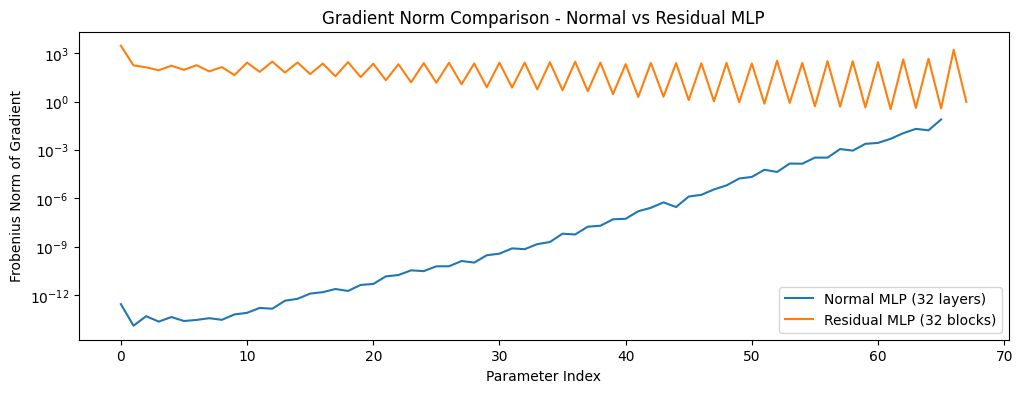

In [80]:
plt.figure(figsize=(12, 4))
plt.plot(mlp_grad_norms)
plt.plot(res_grad_norms)
plt.xlabel('Parameter Index')
plt.ylabel('Frobenius Norm of Gradient')
plt.yscale('log')
plt.legend(['Normal MLP (32 layers)', 'Residual MLP (32 blocks)'])
plt.title('Gradient Norm Comparison - Normal vs Residual MLP')
plt.show()

### (This zig-zag is expected and reflects the difference between weight and bias gradients)

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [81]:
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
ds_test  = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

100%|██████████| 170M/170M [00:19<00:00, 8.90MB/s] 


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [10]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [11]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [12]:
# Your code here.